# Detecting true introgressed tracts from simulated tree sequences

This notebook works on a tree sequence file saved by a [slendr](http://www.slendr.net) simulation framework from a model defined in `introgression.Rmd`.

In [1]:
trees_file = "results/output_ts.trees"

In [2]:
import random
from itertools import chain
from collections import defaultdict

import tskit
import pyslim
import pandas
import numpy
import matplotlib.pyplot as plt
import tqdm.notebook
from IPython.display import display, SVG

random.seed(314159265)

In [3]:
populations = pandas.read_table("model/populations.tsv")

Load the complete tree sequence output:

In [4]:
ts = pyslim.load(trees_file)
ts

Get nodes (chromosomes) of remembered individuals and simplify the tree sequence only to those nodes to make it simpler:

In [5]:
remembered_nodes = list(chain.from_iterable(
    ind.nodes for ind in ts.individuals()
    if ind.flags & pyslim.INDIVIDUAL_REMEMBERED
))

ts = ts.simplify(remembered_nodes)

ts

In [6]:
def plot_tree(tree, populations, node_labels=None):
    styles = []
    # Create a style for each population, programmatically (or just type the string by hand)
    for colour, p in zip(['red', 'green', 'blue', "orange"], ts_small.populations()):
        # target the symbols only (class "sym")
        s = f".node.p{p.id} > .sym " + "{" + f"fill: {colour}" + "}"
        styles.append(s)
        name = populations.query(f"pop_id == {p.id}")["pop"].values[0]
        print(f'"{s}" applies to nodes from population {name} (id {p.id})')
    css_string = " ".join(styles)
    print(f'CSS string applied:\n    "{css_string}"')
    node_labels = {} if not node_labels else node_labels
    display(SVG(tree.draw_svg(size=(700, 400), node_labels=node_labels, style=css_string)))

Iterate over all trees and detect those which indicate Neanderthal introgression into Eurasians:

In [7]:
def get_introgressed_leaves(tree, neand_id):
    start, end = tree.interval

    admixed_list = []
    for root in tree.roots:
        # is the current root rooted in a Neanderthal population?
        if tree.population(root) == neand_id:
            # if it is, collect all non-Neanderthal nodes under this root
            # (these are Eurasians carrying Neanderthal introgression at this locus)
            admixed = [node for node in tree.leaves(root)
                       if tree.population(node) != neand_id]
            admixed_list.extend(admixed)

    return admixed_list

In [8]:
def detect_introgression(ts, neand_id):
    result = []

    for tree in tqdm.notebook.tqdm_notebook(ts.trees()):
        leaves = get_introgressed_leaves(tree, neand_id)
        start, end = tree.interval
        result.append((start, end, leaves))

    segments = pandas.DataFrame(result, columns=["start", "end", "node"]) \
        .explode("node") \
        .dropna() \
        .sort_values(by=["node", "start"]) \
        .reset_index(drop=True) \
    
    return segments

In [13]:
def merge_adjacent(segments):
    all_merged = []

    for node in tqdm.notebook.tqdm_notebook(segments.node.unique()):
        node_segments = []

        for i, seg in enumerate(segments.query(f"node == {node}").itertuples()):
            if i == 0: # initialize detection of continuous segments with the first segment
                segment_start, prev_end = seg.start, seg.end
            elif seg.start == prev_end: # the current segment starts where the previous ended -- continue
                prev_end = seg.end
            else: # end the continuous segment, start a new one
                node_segments.append((segment_start, prev_end, node))
                segment_start, prev_end = seg.start, seg.end

        all_merged.append(node_segments)

    all_merged = list(chain.from_iterable(all_merged))

    segments = pandas.DataFrame(all_merged, columns=["start", "end", "node"]) \
        .sort_values(by=["node", "start"]) \
        .reset_index(drop=True)

    return segments

In [10]:
segments = detect_introgression(ts, neand_id=0)

  0%|          | 0/421237 [00:00<?, ?it/s]

In [15]:
len(segments.node.unique())

556

In [16]:
merged_segments = merge_adjacent(segments)

  0%|          | 0/556 [00:00<?, ?it/s]

In [17]:
len(merged_segments.node.unique())

556

Plot maps of Neanderthal tracts in selected chromosomes:

True archaic ancestry on EUR chromosome ID #626: 2.53%
True archaic ancestry on EUR chromosome ID #642: 2.13%
True archaic ancestry on EUR chromosome ID #656: 2.38%
True archaic ancestry on EUR chromosome ID #830: 4.08%
True archaic ancestry on EUR chromosome ID #862: 3.47%
True archaic ancestry on EUR chromosome ID #893: 3.05%
True archaic ancestry on EUR chromosome ID #956: 3.86%
True archaic ancestry on EUR chromosome ID #1117: 2.02%
True archaic ancestry on EUR chromosome ID #1149: 3.39%
True archaic ancestry on EUR chromosome ID #1152: 3.28%


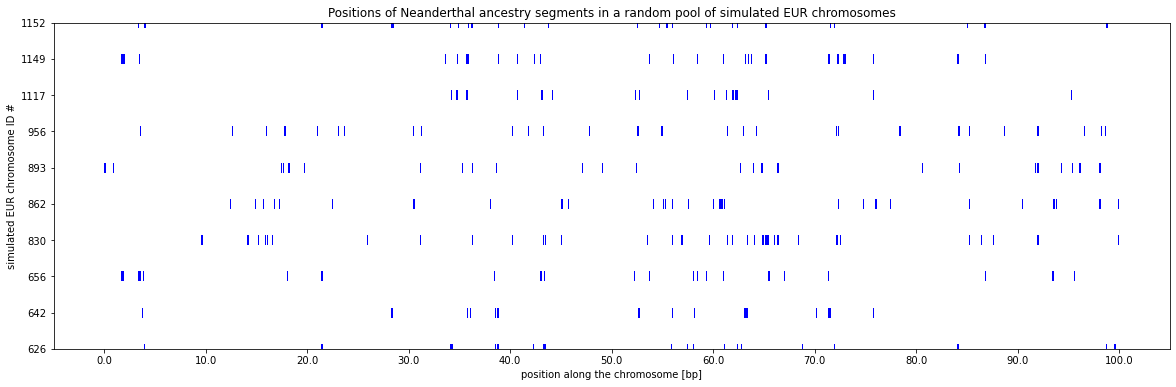

In [12]:
all_nodes = sorted(segments.node.unique())

subset_nodes = random.sample(all_nodes, 10)
subset_segments = segments.loc[segments["node"].isin(subset_nodes)]

nodes = sorted(subset_segments.node.unique())

fig, ax = plt.subplots(figsize=(20, 6))

ax.set_title("Positions of Neanderthal ancestry segments in a random pool of simulated EUR chromosomes")
ax.set_ylabel("simulated EUR chromosome ID #")
ax.set_xlabel("position along the chromosome [bp]")

ax.set_ylim(1, len(nodes))
ax.set_yticks(range(1, len(nodes) + 1))
ax.set_yticklabels(nodes)

positions = numpy.linspace(0, 100e6, 11)
ax.set_xticks(positions)
ax.set_xticklabels([f"{i/1e6}" for i in positions])

for i, node in enumerate(nodes, start=1):
    node_segments = segments.query(f"node == {node}")

    for segment in node_segments.itertuples():
        ax.hlines(y=i, xmin=segment.start, xmax=segment.end, linewidth=10, color='b')
    neand_proportion = (node_segments.end - node_segments.start).sum()/100e6

    print(f"True archaic ancestry on EUR chromosome ID #{node}: {100 * neand_proportion:.2f}%")

plt.show()

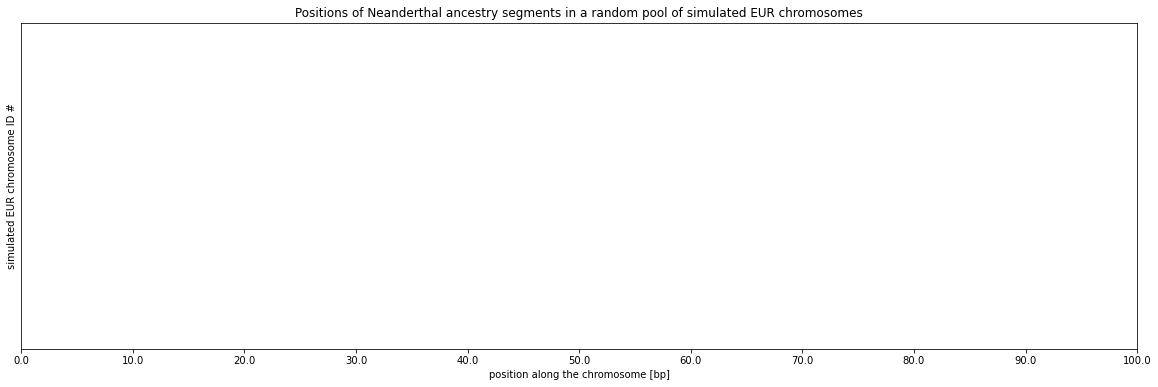

In [37]:
subset_segments = merged_segments.loc[merged_segments["node"].isin(subset_nodes)]

nodes = sorted(subset_segments.node.unique())

fig, ax = plt.subplots(figsize=(20, 6))

ax.set_title("Positions of Neanderthal ancestry segments in a random pool of simulated EUR chromosomes")
ax.set_ylabel("simulated EUR chromosome ID #")
ax.set_xlabel("position along the chromosome [bp]")

ax.set_ylim(1, len(nodes))
ax.set_yticks(range(1, len(nodes) + 1))
ax.set_yticklabels(nodes)

positions = numpy.linspace(0, 100e6, 11)
ax.set_xticks(positions)
ax.set_xticklabels([f"{i/1e6}" for i in positions])

for i, node in enumerate(nodes, start=1):
    node_segments = merged_segments.query(f"node == {node}")

    for segment in node_segments.itertuples():
        ax.hlines(y=i, xmin=segment.start, xmax=segment.end, linewidth=10, color='b')
    neand_proportion = (node_segments.end - node_segments.start).sum()/100e6

    print(f"True archaic ancestry on EUR chromosome ID #{node}: {100 * neand_proportion:.2f}%")

plt.show()

Extract only a subset of all nodes from all populations for easier plotting of trees:

In [7]:
ts.tables.populations

id,metadata
0,"{'slim_id': 0, 'selfing_fraction': 0.0, 'female_cloning_fraction': ..."
1,"{'slim_id': 1, 'selfing_fraction': 0.0, 'female_cloning_fraction': ..."
2,"{'slim_id': 2, 'selfing_fraction': 0.0, 'female_cloning_fraction': ..."
3,"{'slim_id': 3, 'selfing_fraction': 0.0, 'female_cloning_fraction': ..."


In [8]:
neand_id = 0

In [9]:
neand_nodes = list(ts.samples(population=neand_id))

In [10]:
amh_nodes = list(chain.from_iterable(
    random.sample(list(ts.samples(population=pop_id)), 10)
    for pop_id in range(1, ts.num_populations)
))

In [11]:
subset_nodes = neand_nodes + amh_nodes

In [12]:
ts_small = ts.simplify(subset_nodes)

In [13]:
tree = ts_small.first()
tree